# Importamos

In [1]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

import pandas as pd 
import numpy as np
import sklearn as sk
import seaborn as sns
import pydotplus
from six import StringIO
from IPython.display import Image  
from matplotlib import pyplot as plt
from dict_paises import COUNTRY_ALPHA3_TO_COUNTRY_ALPHA2, COUNTRY_ALPHA2_TO_CONTINENT
from joblib import dump, load

from sklearn.model_selection import StratifiedKFold, KFold,RandomizedSearchCV, train_test_split, cross_validate
from sklearn.tree import DecisionTreeClassifier, export_graphviz, export_text
from sklearn.metrics import confusion_matrix, classification_report , f1_score, make_scorer, precision_score, recall_score, accuracy_score,f1_score
from sklearn.preprocessing import MinMaxScaler
from sklearn import tree 

#Si estamos  en colab tenemos que instalar la libreria "dtreeviz" aparte. 
if IN_COLAB == True:
    !pip install 'dtreeviz'
import dtreeviz.trees as dtreeviz

#Para eliminar los warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

## Cargamos el dataframe de testeo

In [2]:
hotelsdfTesteoOriginal = pd.read_csv("./hotels_test.csv")
hotelsdfTesteo = hotelsdfTesteoOriginal.copy()

# Arbol de decisiones sin optimizacion

Vamos a comenzar creando un arbol de decisiones que tenga en cuenta todas las columnas. \
Luego, vamos a realizar una optimizacion y vamos a optimizar dicho arbol para luego comparar resultados.

## Cargamos nuestro dataframe del checkpoint pasado

Vamos a crear una copia de nuestro dataframe para la creacion del arbol

In [3]:
hotelsdfCheckpoint1 = pd.read_csv("./dataframeCheckpoint1.csv")
hotelsdfArbol = hotelsdfCheckpoint1.copy()
print("El data frame esta compuesto por "f"{hotelsdfArbol.shape[0]}"" filas y "f"{hotelsdfArbol.shape[1]}"" columnas")

El data frame esta compuesto por 56883 filas y 33 columnas


Un vistazo básico a la información contenida en el dataframe:

In [4]:
pd.concat([hotelsdfArbol.head(2), hotelsdfArbol.sample(5), hotelsdfArbol.tail(2)])

Unnamed: 0    hotel_name  lead_time  arrival_year arrival_month  \
0               0    City Hotel         49          2016     September   
1               1  Resort Hotel          4          2015       October   
30702       33390    City Hotel          2          2017      February   
34423       37444    City Hotel         20          2017       January   
45886       49944  Resort Hotel        198          2017        August   
26580       28927    City Hotel         90          2016        August   
44316       48255    City Hotel        257          2015          July   
56881       61911  Resort Hotel        143          2015       October   
56882       61912    City Hotel         57          2016         April   

       arrival_week_number  arrival_month_day  weekend_nights_num  \
0                       37                  5                   1   
1                       44                 31                   0   
30702                    9                 27                   1   
34423                    1                  1                   1   
45886                   34                 24                   2   
26580                   35                 21                   2   
44316                   27                  1                   0   
56881                   41                 10                   2   
56882                   17                 17                   2   

       week_nights_num  adult_num  ...  days_in_waiting_list    customer_type  \
0                    2          1  ...                     0        Transient   
1                    1          2  ...                     0        Transient   
30702                3          2  ...                     0        Transient   
34423                0          1  ...                     0  Transient-Party   
45886                5          2  ...                     0        Transient   
26580                0          3  ...                     0        Transient   
44316                2          2  ...                     0        Transient   
56881                5          2  ...                     0        Transient   
56882                5          2  ...                     0        Transient   

      average_daily_rate required_car_parking_spaces_num special_requests_num  \
0                 115.50                               0                    1   
1                  42.00                               1                    0   
30702              74.80                               0                    0   
34423              65.00                               0                    0   
45886             204.75                               0                    0   
26580             150.30                               0                    2   
44316             101.50                               0                    0   
56881              36.05                               0                    0   
56882             143.29                               0                    0   

      reservation_status  reservation_status_date  \
0               Canceled               2016-08-25   
1              Check-Out               2015-11-01   
30702          Check-Out               2017-03-03   
34423          Check-Out               2017-01-02   
45886           Canceled               2017-08-14   
26580          Check-Out               2016-08-23   
44316          Check-Out               2015-07-03   
56881           Canceled               2015-07-08   
56882           Canceled               2016-04-09   

                                 booking_id is_canceled dias_totales  
0      7aa4cc6b-b92c-4061-b21d-4f9e0cac4689           1            3  
1      b1428f80-c56c-4ae4-91a9-6962edae08b1           0            1  
30702  5ad58111-ecfa-4c1c-a26f-1147a5719247           0            4  
34423  0da20700-1513-438d-b4eb-e57cb2bad86e           0            1  
45886  52100d97-4833-405e-a930-b2450bbc0147           1            

Vemos que tenemos una columa extra "Unnamed: 0". Esta hace referencia la columna de origen del registro. Procedemos a borrarla

In [5]:
hotelsdfArbol.drop("Unnamed: 0", axis=1, inplace=True)
hotelsdfArbol.reset_index(drop=True)
print()

## Transformacion de las columnas para la creacion del arbol

Para poder usar el arbol de sklearn, tenemos que transformar todas nuestras columnas no numericas a valores numericos. \
Dichas columnas son las siguientes:

In [6]:
valoresAConvertir = hotelsdfArbol.dtypes[(hotelsdfArbol.dtypes !='int64') & (hotelsdfArbol.dtypes !='float64')].index
valoresAConvertir = valoresAConvertir.to_list()
valoresAConvertir

['hotel_name',
 'arrival_month',
 'meal_type',
 'country',
 'market_segment_type',
 'distribution_channel',
 'reserved_room_type',
 'assigned_room_type',
 'deposit_type',
 'customer_type',
 'reservation_status',
 'reservation_status_date',
 'booking_id']

Sin embargo, no todas estas columnas nos van a servir para nuestro analisis.


### Booking ID

Vamos a empezar removiendo booking\_id visto en como no la necesitamos para analisis

In [7]:
hotelsdfArbol.drop("booking_id", axis=1, inplace=True)
hotelsdfArbol.reset_index(drop=True)
valoresAConvertir.remove('booking_id')

### Reservation Status & Reservation status date

Reservation Status nos dice el estado de la reservacion, si fue cancelada o no y reservation status date nos marca la fecha en la que cambio el estado. 
Estas dos columnas nos son redundantes

In [8]:
hotelsdfArbol.drop("reservation_status", axis=1, inplace=True)
hotelsdfArbol.reset_index(drop=True)
valoresAConvertir.remove('reservation_status')

In [9]:
hotelsdfArbol.drop("reservation_status_date", axis=1, inplace=True)
hotelsdfArbol.reset_index(drop=True)
valoresAConvertir.remove('reservation_status_date')

### Country
Country toma una amplia cantidad de valores como vimos en el analisis univariado. Asique decidimos agrupar los paises por continente para poder usar la variable

In [10]:
hotelsdfArbol["continente"] = hotelsdfArbol["country"].replace(COUNTRY_ALPHA3_TO_COUNTRY_ALPHA2)
hotelsdfArbol["continente"] = hotelsdfArbol["continente"].replace(COUNTRY_ALPHA2_TO_CONTINENT)

In [11]:
country = hotelsdfArbol['country'].unique().tolist()
print(country) 

['USA', 'PRT', 'CHE', 'FRA', 'AGO', 'GBR', 'DEU', 'ESP', 'ROU', 'SWE', 'IRL', 'CN', 'ITA', 'NLD', 'NOR', 'MAR', 'BEL', 'ISR', 'KOR', 'IND', 'TUN', 'JPN', 'FIN', 'TUR', 'CHN', 'AUT', 'ZAF', 'LUX', 'BRA', 'POL', 'DNK', 'IRN', 'RUS', 'VEN', 'AUS', 'MLT', 'BGR', 'GEO', 'SRB', 'PHL', 'ARG', 'LVA', 'LTU', 'ARE', 'VNM', 'MOZ', 'THA', 'MEX', 'HUN', 'DZA', 'GAB', 'UKR', 'SVN', 'HRV', 'SVK', 'CHL', 'BLR', 'CPV', 'CRI', 'EST', 'TWN', 'ALB', 'SGP', 'IDN', 'DOM', 'MUS', 'OMN', 'EGY', 'SAU', 'NZL', 'FRO', 'CYP', 'PER', 'CZE', 'GRC', 'ARM', 'COL', 'PAK', 'MDG', 'HKG', 'MYS', 'MKD', 'ISL', 'BIH', 'NGA', 'AZE', 'MAC', 'JEY', 'SUR', 'KWT', 'BGD', 'IRQ', 'MDV', 'GGY', 'VGB', 'ECU', 'URY', 'ETH', 'LBN', 'BOL', 'QAT', 'JOR', 'COM', 'GNB', 'UGA', 'BEN', 'GIB', 'SEN', 'TZA', 'LBY', 'SYC', 'PRY', 'MNE', 'ZWE', 'CAF', 'ATA', 'MWI', 'JAM', 'AND', 'LIE', 'FJI', 'PRI', 'TJK', 'LKA', 'KAZ', 'HND', 'PAN', 'CMR', 'KEN', 'UMI', 'MYT', 'PYF', 'GLP', 'BRB', 'CIV', 'ZMB', 'CUB', 'TGO', 'SYR', 'SDN', 'NAM', 'GHA', 'GTM',

In [12]:
country = hotelsdfArbol['continente'].unique().tolist()
print(country) 

['North America', 'Europe', 'Africa', 'Asia', 'South America', 'Oceania', 'ATA', 'UMI']


Viendo estos resultados vemos que hay dos outliers que no logramos identificar en el analisis univariado.

"ATA" refiere al **continente** de Antartida. Al ser un valor tan fuera de lo comun y tener una sola ocurrencia decidimos eliminarlo del dataframe

In [13]:
hotelsdfArbol.drop((hotelsdfArbol[hotelsdfArbol["country"] == "ATA"].index.values),inplace=True)
hotelsdfArbol.reset_index(drop=True)
print()

"UMI" hace referenca a unas islas cerca de Hawaii. Al ser un unico caso y tener una poblacion de 300 habitantes, decidimos considerarlo como Estados Unidos, es decir America del Norte

Fuentes:
- https://www.iso.org/obp/ui/#iso:code:3166:UM
- https://en.wikipedia.org/wiki/United_States_Minor_Outlying_Islands

In [14]:
hotelsdfArbol.loc[hotelsdfArbol['country'] == "UMI", 'country'] = 'North America'
hotelsdfArbol.loc[hotelsdfArbol['continente'] == "UMI", 'continente'] = 'North America'

Con estos nuevos cambios, la columna continente toma los siguientes valores

In [15]:
continente = hotelsdfArbol['continente'].unique().tolist()
print(continente) 

['North America', 'Europe', 'Africa', 'Asia', 'South America', 'Oceania']


Procedemos a dropear la columna de country

In [16]:
hotelsdfArbol=hotelsdfArbol.drop(['country'], axis='columns', inplace=False)
valoresAConvertir.remove('country')
valoresAConvertir.append('continente')
hotelsdfArbol.reset_index(drop=True)

hotel_name  lead_time  arrival_year arrival_month  \
0        City Hotel         49          2016     September   
1      Resort Hotel          4          2015       October   
2        City Hotel         25          2016       October   
3        City Hotel         26          2016      December   
4        City Hotel        104          2017         March   
...             ...        ...           ...           ...   
56877  Resort Hotel         24          2017       January   
56878    City Hotel          0          2016     September   
56879    City Hotel         10          2017           May   
56880  Resort Hotel        143          2015       October   
56881    City Hotel         57          2016         April   

       arrival_week_number  arrival_month_day  weekend_nights_num  \
0                       37                  5                   1   
1                       44                 31                   0   
2                       42                 13                   0   
3                       51                 12                   2   
4                       12                 19                   2   
...                    ...                ...                 ...   
56877                    4                 27                   0   
56878                   36                  2                   0   
56879                   19                  8                   1   
56880                   41                 10                   2   
56881                   17                 17                   2   

       week_nights_num  adult_num  children_num  ...  deposit_type agent_id  \
0                    2          1             0  ...    No Deposit        9   
1                    1          2             0  ...    No Deposit        0   
2                    1          2             2  ...    No Deposit        9   
3                    5          2             0  ...    Non Refund      154   
4                    5          2             0  ...    No Deposit       20   
...                ...        ...           ...  ...           ...      ...   
56877                2          2             0  ...    No Deposit      240   
56878                1          1             0  ...    No Deposit        0   
56879                2          1             0  ...    No Deposit        0   
56880                5          2             0  ...    Non Refund       96   
56881                5          2             0  ...    No Deposit        9   

      days_in_waiting_list    customer_type  average_daily_rate  \
0                        0        Transient              115.50   
1                        0        Transient               42.00   
2                        0        Transient              229.00   
3                        0        Transient               75.00   
4                        0  Transient-Party               75.00   
...                    ...              ...                 ...   
56877                    0        Transient               48.00   
56878                    0        Transient              149.00   
56879                    0        Transient               95.00   
56880                    0        Transient               36.05   
56881                    0        Transient              143.29   

       required_car_parking_spaces_num special_requests_num is_canceled  \
0                                    0                    1           1   
1                                    1                    0           0   
2                                    0                    2           0   
3                                    0                    0           1   
4                                    0                    1           0   
...                                ...                  ...         ...   
56877                                0                    1           1   
56878                                0                    0           0   
56879 

In [17]:
valoresAConvertir

['hotel_name',
 'arrival_month',
 'meal_type',
 'market_segment_type',
 'distribution_channel',
 'reserved_room_type',
 'assigned_room_type',
 'deposit_type',
 'customer_type',
 'continente']

### One hot encoding

Vamos a transformar dichas variables categoricas con la tecnica de one hot encoding. \
Esto va a crear una serie de nuevas columnas con todos los posibles de la variable categorica. En cada columna va a haber un 1 o un 0 para indicar el valor del registro de esa variable. \
Una de las columnas (en este caso la primera) es eliminada ya que, si todas las otras columnas son falsas, significa que la variable toma el valor de la columna eliminada. \
Esto lo podemos hacer gracias a que eliminamos todos nuestros valores faltantes en las secciones anteriores.

In [18]:
hotelsdfArbol = pd.get_dummies(hotelsdfArbol, columns=valoresAConvertir, drop_first=True)

Vamos a observar como nos quedo el dataframe despues del one hot encoding

In [19]:
hotelsdfArbol.head()

lead_time  arrival_year  arrival_week_number  arrival_month_day  \
0         49          2016                   37                  5   
1          4          2015                   44                 31   
2         25          2016                   42                 13   
3         26          2016                   51                 12   
4        104          2017                   12                 19   

   weekend_nights_num  week_nights_num  adult_num  children_num  babies_num  \
0                   1                2          1             0           0   
1                   0                1          2             0           0   
2                   0                1          2             2           0   
3                   2                5          2             0           0   
4                   2                5          2             0           0   

   is_repeated_guest  ...  deposit_type_Non Refund  deposit_type_Refundable  \
0                  0  ...                        0                        0   
1                  0  ...                        0                        0   
2                  0  ...                        0                        0   
3                  0  ...                        1                        0   
4                  0  ...                        0                        0   

   customer_type_Group  customer_type_Transient  \
0                    0                        1   
1                    0                        1   
2                    0                        1   
3                    0                        1   
4                    0                        0   

   customer_type_Transient-Party  continente_Asia  continente_Europe  \
0                              0                0                  0   
1                              0                0                  1   
2                              0                0                  1   
3                              0                0                  1   
4                              1                0                  1   

   continente_North America  continente_Oceania  continente_South America  
0                         1                   0                         0  
1                         0                   0                         0  
2                         0                   0                         0  
3                         0                   0                         0  
4                         0                   0                         0  

[5 rows x 70 columns]

Observamos que hay una **gran** cantidad de columnas

### Aplicamos mismas modificaciones al dataset de testeo

Ahora vamos a aplicar las mismas modificaciones y encodings al dataframe de testeo para poder aplicarle el modelo

Empezamos cambiando el nombre de las columnas para que coincida con el de nuestro dataframe

In [20]:
nuevas_columnas = {
    'adr':'average_daily_rate',
    'adults':'adult_num',
    'agent':'agent_id',
    'arrival_date_day_of_month':'arrival_month_day',
    'arrival_date_month':'arrival_month',
    'arrival_date_week_number':'arrival_week_number',
    'arrival_date_year':'arrival_year',
    'assigned_room_type':'assigned_room_type',
    'babies':'babies_num',
    'booking_changes':'booking_changes_num',
    'children':'children_num',
    'company':'company_id',
    'country':'country',
    'customer_type':'customer_type',
    'days_in_waiting_list':'days_in_waiting_list',
    'deposit_type':'deposit_type',
    'distribution_channel':'distribution_channel',
    'hotel':'hotel_name',
    'id':'booking_id',
    'is_repeated_guest':'is_repeated_guest',
    'lead_time':'lead_time',
    'market_segment':'market_segment_type',
    'meal':'meal_type',
    'previous_bookings_not_canceled':'previous_bookings_not_canceled_num',
    'previous_cancellations':'previous_cancellations_num',
    'required_car_parking_spaces':'required_car_parking_spaces_num',
    'reserved_room_type':'reserved_room_type',
    'stays_in_weekend_nights':'weekend_nights_num',
    'stays_in_week_nights':'week_nights_num',
    'total_of_special_requests':'special_requests_num',
}

hotelsdfTesteo.rename(columns = nuevas_columnas, inplace = True)

Antes de nada, vamos a procesar todos los datos faltantes del dataframe.

#### Dias Totales

Anadimos la columna que creamos en el checkpoint 1

In [21]:
hotelsdfTesteo["dias_totales"] = hotelsdfTesteo["week_nights_num"] + hotelsdfTesteo["weekend_nights_num"]

#### Datos faltantes

In [22]:
hotelsdfTesteo.isnull().sum()

hotel_name                                0
lead_time                                 0
arrival_year                              0
arrival_month                             0
arrival_week_number                       0
arrival_month_day                         0
weekend_nights_num                        0
week_nights_num                           0
adult_num                                 0
children_num                              0
babies_num                                0
meal_type                                 0
country                                  95
market_segment_type                       0
distribution_channel                      0
is_repeated_guest                         0
previous_cancellations_num                0
previous_bookings_not_canceled_num        0
reserved_room_type                        0
assigned_room_type                        0
booking_changes_num                       0
deposit_type                              0
agent_id                        

In [23]:
print("Vemos que 'company id' tiene un " + str( (hotelsdfTesteo["company_id"].isnull().sum() * 100) / len(hotelsdfTesteo)  ) + "% de datos faltantes.")
print("Por esto decidimos eliminar la columna (tanto en el dataset de testeo como en el de entrenamiento)")

Vemos que 'company id' tiene un 95.03674392312041% de datos faltantes.
Por esto decidimos eliminar la columna (tanto en el dataset de testeo como en el de entrenamiento)


In [24]:
hotelsdfTesteo.drop("company_id", axis=1, inplace=True)
hotelsdfTesteo.reset_index(drop=True)

hotel_name  lead_time  arrival_year arrival_month  \
0        City Hotel        277          2016      November   
1        City Hotel        286          2016           May   
2        City Hotel          0          2016        August   
3      Resort Hotel        196          2016       October   
4      Resort Hotel        232          2016      November   
...             ...        ...           ...           ...   
26530    City Hotel         31          2017         April   
26531    City Hotel        130          2016     September   
26532  Resort Hotel         45          2016        August   
26533    City Hotel        164          2017        August   
26534  Resort Hotel        136          2016         March   

       arrival_week_number  arrival_month_day  weekend_nights_num  \
0                       46                  7                   1   
1                       20                 11                   0   
2                       35                 23                   0   
3                       44                 29                   2   
4                       48                 26                   2   
...                    ...                ...                 ...   
26530                   16                 21                   2   
26531                   36                  3                   2   
26532                   35                 22                   1   
26533                   32                 10                   2   
26534                   13                 24                   0   

       week_nights_num  adult_num  children_num  ...  deposit_type agent_id  \
0                    2          2           0.0  ...    Non Refund      NaN   
1                    4          2           0.0  ...    No Deposit     30.0   
2                    1          3           0.0  ...    No Deposit      NaN   
3                    5          2           2.0  ...    No Deposit    240.0   
4                    1          2           0.0  ...    Non Refund     11.0   
...                ...        ...           ...  ...           ...      ...   
26530                3          2           0.0  ...    No Deposit     21.0   
26531                1          2           0.0  ...    No Deposit     42.0   
26532                1          2           0.0  ...    No Deposit    240.0   
26533                4          2           0.0  ...    No Deposit     85.0   
26534                3          2           0.0  ...    No Deposit    387.0   

      days_in_waiting_list    customer_type average_daily_rate  \
0                        0        Transient             100.00   
1                      176  Transient-Party             101.00   
2                        0        Transient             225.00   
3                        0        Transient              96.00   
4                        0        Transient              30.00   
...                    ...              ...                ...   
26530                    0  Transient-Party              85.00   
26531                    0        Transient              80.75   
26532                    0        Transient             231.00   
26533                    0        Transient              80.10   
26534                    0  Transient-Party              84.00   

       required_car_parking_spaces_num  special_requests_num  \
0                                    0                     0   
1                                    0                     0   
2                                    0                     2   
3                                    0                     0   
4                                    0                     0   
...                                ...                   ...   
26530                                0                     0   
26531                                0                     0   
26532                                0                     0   
26533                                0               

### Valores a convertir

Siempre posible, vamos a aplicar el mismo criterio que arriba

In [25]:
valoresAConvertirTesteo = hotelsdfTesteo.dtypes[(hotelsdfTesteo.dtypes !='int64') & (hotelsdfTesteo.dtypes !='float64')].index
valoresAConvertirTesteo = valoresAConvertirTesteo.to_list()
valoresAConvertirTesteo

['hotel_name',
 'arrival_month',
 'meal_type',
 'country',
 'market_segment_type',
 'distribution_channel',
 'reserved_room_type',
 'assigned_room_type',
 'deposit_type',
 'customer_type',
 'reservation_status_date',
 'booking_id']

#### Booking ID

In [26]:
hotelsdfTesteo.drop("booking_id", axis=1, inplace=True)
hotelsdfTesteo.reset_index(drop=True)
valoresAConvertirTesteo.remove('booking_id')

#### Agent ID

Tomamos el mismo criterio que el checkpoint 1. Transformamos a 0

In [27]:
hotelsdfTesteo.loc[hotelsdfTesteo['agent_id'].isnull(), 'agent_id'] = 0

#### Reservation Status & Reservation status date


Dropeamos estas columnas debido a que no nos dan ninguna informacion adicional

In [28]:
hotelsdfTesteo.drop("reservation_status_date", axis=1, inplace=True)
hotelsdfTesteo.reset_index(drop=True)
valoresAConvertirTesteo.remove('reservation_status_date')

#### Country y Continents

Para los valores faltantes de country tomamos el mismo criterio del checkpoint 1. Los convertimos en portugal

In [29]:
hotelsdfTesteo.loc[hotelsdfTesteo['country'].isnull(), 'country'] = 'PRT'

In [30]:
hotelsdfTesteo["continente"] = hotelsdfTesteo["country"].replace(COUNTRY_ALPHA3_TO_COUNTRY_ALPHA2)
hotelsdfTesteo["continente"] = hotelsdfTesteo["continente"].replace(COUNTRY_ALPHA2_TO_CONTINENT)

In [31]:
country = hotelsdfTesteo['country'].unique().tolist()
valoresAConvertirTesteo.append("continente")
print(country) 

['PRT', 'FRA', 'DEU', 'CN', 'GBR', 'ITA', 'IRL', 'USA', 'ESP', 'SWE', 'RWA', 'NLD', 'AUT', 'AUS', 'RUS', 'CHE', 'CHN', 'DNK', 'POL', 'BEL', 'BRA', 'TUR', 'NOR', 'EST', 'ISL', 'VEN', 'ISR', 'JPN', 'MAR', 'ATF', 'HRV', 'IRN', 'LTU', 'FIN', 'PER', 'LVA', 'KOR', 'LUX', 'JAM', 'HUN', 'DZA', 'TWN', 'ZWE', 'THA', 'ROU', 'IND', 'ARG', 'CHL', 'MEX', 'ARE', 'MOZ', 'SAU', 'URY', 'ECU', 'GRC', 'UZB', 'AGO', 'GIB', 'CZE', 'ZAF', 'TUN', 'TJK', 'BGR', 'COL', 'SRB', 'EGY', 'VNM', 'CYP', 'OMN', 'NZL', 'SUR', 'SVK', 'LBY', 'SGP', 'LBN', 'BLR', 'SEN', 'HKG', 'MDV', 'UKR', 'BIH', 'IDN', 'MAC', 'KWT', 'JOR', 'SLV', 'MYS', 'DMA', 'CMR', 'PHL', 'ASM', 'MLT', 'BGD', 'SVN', 'GHA', 'JEY', 'NGA', 'MCO', 'CPV', 'PAK', 'TZA', 'KAZ', 'BOL', 'DJI', 'QAT', 'IRQ', 'GNB', 'IMN', 'DOM', 'LIE', 'PRI', 'CUB', 'TMP', 'BHR', 'MKD', 'CAF', 'ALB', 'AND', 'MWI', 'PRY', 'LKA', 'GEO', 'CRI', 'UGA', 'GGY', 'ATA', 'SMR', 'BFA', 'MLI', 'BRB', 'GLP', 'KHM', 'STP', 'GAB', 'NIC']


In [32]:
continentes = hotelsdfTesteo['continente'].unique().tolist()
print(continentes) 

['Europe', 'Asia', 'North America', 'Africa', 'Oceania', 'South America', 'ATF', 'ATA']


Tal como ocurrio con el dataset de Train, observamos que hay algunos continente (y por tanto sus paises y registros asociados) que parecen ser outliers.
Los estudiamos

In [33]:
hotelsdfTesteo[ hotelsdfTesteo['continente'] =="ATA"]

hotel_name  lead_time  arrival_year arrival_month  arrival_week_number  \
17499  City Hotel         34          2016       October                   42   

       arrival_month_day  weekend_nights_num  week_nights_num  adult_num  \
17499                 13                   0                2          1   

       children_num  ...  booking_changes_num deposit_type agent_id  \
17499           0.0  ...                    0   No Deposit     14.0   

      days_in_waiting_list customer_type  average_daily_rate  \
17499                    0     Transient               175.5   

       required_car_parking_spaces_num  special_requests_num dias_totales  \
17499                                0                     0            2   

      continente  
17499        ATA  

[1 rows x 30 columns]

Hay un registro correspondiente a "Antartida". como no podemos dropearlo, le ponemos de continente "north america".\
Le asignamos el valor de America del norte debido a que estados unidos es el pais con mas bases en la antartica

In [34]:
hotelsdfTesteo.loc[hotelsdfTesteo['continente'] == "ATA", 'continente'] = "North America"

In [35]:
hotelsdfTesteo[ hotelsdfTesteo['continente'] =="ATF"]

hotel_name  lead_time  arrival_year arrival_month  arrival_week_number  \
401  City Hotel        116          2017          July                   27   

     arrival_month_day  weekend_nights_num  week_nights_num  adult_num  \
401                  2                   2                0          2   

     children_num  ...  booking_changes_num deposit_type agent_id  \
401           0.0  ...                    0   No Deposit      9.0   

    days_in_waiting_list customer_type  average_daily_rate  \
401                    0     Transient               126.0   

     required_car_parking_spaces_num  special_requests_num dias_totales  \
401                                0                     0            2   

    continente  
401        ATF  

[1 rows x 30 columns]

"ATF", que es la sigla de Fr. So. Ant. Tr (French southern and antartic lands).
Ponemos su contienente en Europa. 

In [36]:
hotelsdfTesteo.loc[hotelsdfTesteo['continente'] == "ATF", 'continente'] = "Europe"

In [37]:
hotelsdfTesteo[hotelsdfTesteo['continente'] =="ATF"]

Empty DataFrame
Columns: [hotel_name, lead_time, arrival_year, arrival_month, arrival_week_number, arrival_month_day, weekend_nights_num, week_nights_num, adult_num, children_num, babies_num, meal_type, country, market_segment_type, distribution_channel, is_repeated_guest, previous_cancellations_num, previous_bookings_not_canceled_num, reserved_room_type, assigned_room_type, booking_changes_num, deposit_type, agent_id, days_in_waiting_list, customer_type, average_daily_rate, required_car_parking_spaces_num, special_requests_num, dias_totales, continente]
Index: []

[0 rows x 30 columns]

#### Analisis de valores faltantes de continente

In [38]:
hotelsdfTesteo[hotelsdfTesteo['continente'].isna()]

Empty DataFrame
Columns: [hotel_name, lead_time, arrival_year, arrival_month, arrival_week_number, arrival_month_day, weekend_nights_num, week_nights_num, adult_num, children_num, babies_num, meal_type, country, market_segment_type, distribution_channel, is_repeated_guest, previous_cancellations_num, previous_bookings_not_canceled_num, reserved_room_type, assigned_room_type, booking_changes_num, deposit_type, agent_id, days_in_waiting_list, customer_type, average_daily_rate, required_car_parking_spaces_num, special_requests_num, dias_totales, continente]
Index: []

[0 rows x 30 columns]

Vemos que hay una serie de registros que no tienen el dato del pais. Sin embargo, no son muchos. Debido a esto, vamos a asignarle estos registros el valor de aquel contiente que tenga la mayor cantidad de registros

Text(0, 0.5, 'Cantidad de registros')

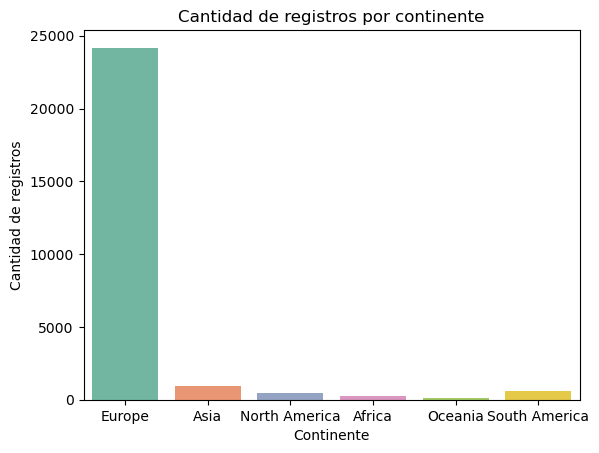

In [39]:
sns.countplot(data = hotelsdfTesteo, x = 'continente', palette= 'Set2')
plt.title('Cantidad de registros por continente')
plt.xlabel('Continente')
plt.ylabel('Cantidad de registros')

Vemos que el continente con mayor cantidad de registros es europa, asique lo asignamos a ese valor

In [40]:
hotelsdfTesteo.loc[hotelsdfTesteo['continente'].isnull(), 'country'] = 'Europe'

Miro q se hayan cambiado bien todos los continentes y no haya valores raros

In [41]:
continentes = hotelsdfTesteo['continente'].unique().tolist()
print(continentes)

['Europe', 'Asia', 'North America', 'Africa', 'Oceania', 'South America']


Como hicimos con el dataset de train, y ya habiendo procesado la columna continente, dropeamos la columna country

In [42]:
hotelsdfTesteo=hotelsdfTesteo.drop(['country'], axis='columns', inplace=False)
hotelsdfTesteo.reset_index(drop=True)
valoresAConvertirTesteo.remove('country')

#### previous bookings not cancelled

Al igual q en el train, dropeamos esta col

In [43]:
hotelsdfTesteo=hotelsdfTesteo.drop(['previous_bookings_not_canceled_num'], axis='columns', inplace=False)
hotelsdfTesteo.reset_index(drop=True)

hotel_name  lead_time  arrival_year arrival_month  \
0        City Hotel        277          2016      November   
1        City Hotel        286          2016           May   
2        City Hotel          0          2016        August   
3      Resort Hotel        196          2016       October   
4      Resort Hotel        232          2016      November   
...             ...        ...           ...           ...   
26530    City Hotel         31          2017         April   
26531    City Hotel        130          2016     September   
26532  Resort Hotel         45          2016        August   
26533    City Hotel        164          2017        August   
26534  Resort Hotel        136          2016         March   

       arrival_week_number  arrival_month_day  weekend_nights_num  \
0                       46                  7                   1   
1                       20                 11                   0   
2                       35                 23                   0   
3                       44                 29                   2   
4                       48                 26                   2   
...                    ...                ...                 ...   
26530                   16                 21                   2   
26531                   36                  3                   2   
26532                   35                 22                   1   
26533                   32                 10                   2   
26534                   13                 24                   0   

       week_nights_num  adult_num  children_num  ...  booking_changes_num  \
0                    2          2           0.0  ...                    0   
1                    4          2           0.0  ...                    0   
2                    1          3           0.0  ...                    0   
3                    5          2           2.0  ...                    0   
4                    1          2           0.0  ...                    0   
...                ...        ...           ...  ...                  ...   
26530                3          2           0.0  ...                    0   
26531                1          2           0.0  ...                    0   
26532                1          2           0.0  ...                    0   
26533                4          2           0.0  ...                    0   
26534                3          2           0.0  ...                    0   

      deposit_type agent_id days_in_waiting_list    customer_type  \
0       Non Refund      0.0                    0        Transient   
1       No Deposit     30.0                  176  Transient-Party   
2       No Deposit      0.0                    0        Transient   
3       No Deposit    240.0                    0        Transient   
4       Non Refund     11.0                    0        Transient   
...            ...      ...                  ...              ...   
26530   No Deposit     21.0                    0  Transient-Party   
26531   No Deposit     42.0                    0        Transient   
26532   No Deposit    240.0                    0        Transient   
26533   No Deposit     85.0                    0        Transient   
26534   No Deposit    387.0                    0  Transient-Party   

       average_daily_rate required_car_parking_spaces_num  \
0                  100.00                               0   
1                  101.00                               0   
2                  225.00                               0   
3                   96.00                               0   
4                   30.00                               0   
...                   ...                             ...   
26530               85.00                               0   
26531               80.75                               0   
26532              231.00                               0   
26533               80.10                               0   
26534     

In [44]:
hotelsdfTesteo.isnull().sum()

hotel_name                         0
lead_time                          0
arrival_year                       0
arrival_month                      0
arrival_week_number                0
arrival_month_day                  0
weekend_nights_num                 0
week_nights_num                    0
adult_num                          0
children_num                       0
babies_num                         0
meal_type                          0
market_segment_type                0
distribution_channel               0
is_repeated_guest                  0
previous_cancellations_num         0
reserved_room_type                 0
assigned_room_type                 0
booking_changes_num                0
deposit_type                       0
agent_id                           0
days_in_waiting_list               0
customer_type                      0
average_daily_rate                 0
required_car_parking_spaces_num    0
special_requests_num               0
dias_totales                       0
c

### One hot encoding del testeo

De la misma manera al dataset de pruebas aplicamos one hot encoding sobre las columnas de variables cualitativas

In [45]:
hotelsdfTesteo = pd.get_dummies(hotelsdfTesteo, columns=valoresAConvertirTesteo, drop_first=True)
hotelsdfTesteo.head()

lead_time  arrival_year  arrival_week_number  arrival_month_day  \
0        277          2016                   46                  7   
1        286          2016                   20                 11   
2          0          2016                   35                 23   
3        196          2016                   44                 29   
4        232          2016                   48                 26   

   weekend_nights_num  week_nights_num  adult_num  children_num  babies_num  \
0                   1                2          2           0.0           0   
1                   0                4          2           0.0           0   
2                   0                1          3           0.0           0   
3                   2                5          2           2.0           0   
4                   2                1          2           0.0           0   

   is_repeated_guest  ...  deposit_type_Non Refund  deposit_type_Refundable  \
0                  0  ...                        1                        0   
1                  0  ...                        0                        0   
2                  0  ...                        0                        0   
3                  0  ...                        0                        0   
4                  0  ...                        1                        0   

   customer_type_Group  customer_type_Transient  \
0                    0                        1   
1                    0                        0   
2                    0                        1   
3                    0                        1   
4                    0                        1   

   customer_type_Transient-Party  continente_Asia  continente_Europe  \
0                              0                0                  1   
1                              1                0                  1   
2                              0                0                  1   
3                              0                0                  1   
4                              0                0                  1   

   continente_North America  continente_Oceania  continente_South America  
0                         0                   0                         0  
1                         0                   0                         0  
2                         0                   0                         0  
3                         0                   0                         0  
4                         0                   0                         0  

[5 rows x 72 columns]

### Corroboracion de columnas

Despues de todas estas transformaciones vamos a corrobar que los dataframes tengan la misma cantidad de columnas.

In [46]:
set_test = set(hotelsdfTesteo.columns)
set_arbol = set(hotelsdfArbol.columns)

missing = list(sorted(set_test - set_arbol))
added = list(sorted(set_arbol - set_test))

print('Faltan en arbol:', missing)
print('Sobran en arbol:', added)

Faltan en arbol: ['assigned_room_type_P', 'reserved_room_type_L', 'reserved_room_type_P']
Sobran en arbol: ['is_canceled']


Vemos que en el dataframe del arbol nos sobra la columna "is canceled", cosa que hace sentido ya que esa es la columna con la que vamos a entrenar al dataset. Sin embargo, vemos que tambien hay 3 columnas que faltan en el dataset de arbol. 

Vamos a reasignar los valores de las columnas de test para que coincidan.

El siguiente codigo nos calcula cuantas personas tiene cada tipo de cuarto

In [47]:
cantDeCuartos = {}
cantidadDeCasosSumados = 0

cantDeCuartos["A"] = 0 #Arrancamos asignado 0 a los cuartos de A. Estos fueron removidos por el one hot. Lo vamos a calcular al final.
for letra in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']:
    tipoDeCuarto = 'reserved_room_type_' + letra
    cantidadDeCasosSumados += 1
    if tipoDeCuarto not in hotelsdfTesteo.columns:
        continue
    hotelsdfTesteo[tipoDeCuarto]
    resultado = hotelsdfTesteo[hotelsdfTesteo[tipoDeCuarto] == 1][tipoDeCuarto].sum()
    cantDeCuartos[letra] = resultado

cuartosA = len(hotelsdfTesteo) - cantidadDeCasosSumados
cantDeCuartos["A"] = cuartosA


cantDeCuartos

{'A': 26509,
 'B': 241,
 'C': 202,
 'D': 4176,
 'E': 1352,
 'F': 630,
 'G': 442,
 'H': 118,
 'L': 3,
 'P': 5}

Vemos que L y P tienen una extremadamente pequena cantidad de apariciones. \
Lo vamos a anadir al roomtype A al ser el que tiene la mayor cantidad de apariciones.

Para anadirlos a la columna a, simplemente tenemos que eliminar las columnas L y P (ya que la columna A es la eliminada por el one hot)

In [48]:
hotelsdfTesteo.drop("reserved_room_type_L", axis=1, inplace=True)
hotelsdfTesteo.drop("reserved_room_type_P", axis=1, inplace=True)
hotelsdfTesteo.reset_index(drop=True)
print()

Vamos a aplicar el mismo criterio a assigned room type

In [49]:
cantDeCuartos = {}
cantidadDeCasosSumados = 0

cantDeCuartos["A"] = 0 #Arrancamos asignado 0 a los cuartos de A. Estos fueron removidos por el one hot. Lo vamos a calcular al final.
for letra in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']:
    tipoDeCuarto = 'assigned_room_type_' + letra
    cantidadDeCasosSumados += 1
    if tipoDeCuarto not in hotelsdfTesteo.columns:
        continue
    hotelsdfTesteo[tipoDeCuarto]
    resultado = hotelsdfTesteo[hotelsdfTesteo[tipoDeCuarto] == 1][tipoDeCuarto].sum()
    cantDeCuartos[letra] = resultado

cuartosA = len(hotelsdfTesteo) - cantidadDeCasosSumados
cantDeCuartos["A"] = cuartosA


cantDeCuartos

{'A': 26509,
 'B': 439,
 'C': 445,
 'D': 5316,
 'E': 1576,
 'F': 764,
 'G': 517,
 'H': 135,
 'I': 66,
 'K': 54,
 'P': 5}

Aca tambien vemos que P tiene muy pocas aparciones. Asique aplicamos el mismo criterio de antes

In [50]:
hotelsdfTesteo.drop("assigned_room_type_P", axis=1, inplace=True)
hotelsdfTesteo.reset_index(drop=True)
print()

Vemos ahora que nuestras columnas coinciden

In [51]:
set_test = set(hotelsdfTesteo.columns)
set_arbol = set(hotelsdfArbol.columns)

missing = list(sorted(set_test - set_arbol))
added = list(sorted(set_arbol - set_test))

print('Faltan en arbol:', missing)
print('Sobran en arbol:', added)

Faltan en arbol: []
Sobran en arbol: ['is_canceled']


## Entrenamiento del modelo

Se genera un dataset con los datos necesarios para predecir la cancelacion y creamos un dataset conteniendo el target, para luego, generar conjuntos de test y train

In [52]:
hotelsdfArbol_x=hotelsdfArbol.drop(['is_canceled'], axis='columns', inplace=False)


hotelsdfArbol_y = hotelsdfArbol['is_canceled'].copy()

x_train, x_test, y_train, y_test = train_test_split(hotelsdfArbol_x,
                                                    hotelsdfArbol_y, 
                                                    test_size=0.2,  #proporcion 80/20
                                                    random_state=9) #Semilla 9, como el Equipo !!

Ahora ya tenemos generados nuestros conjuntos de train y test; y tenemos nuestro dataframe con los datos numericos, vamos a generar nuestro modelo

Iniciamos con una profundidad maxima arbitraria, en este caso 20 y creamos un arbol utilizando el criterio **Gini** 

Dicho modelo sera uno generado directamente tomando en cuenta todos los valores y sin generar ningun tipo de poda, para observar como se comporta un modelo sin tratar

In [53]:
PROFUNDIDAD_MAX = 20

tree_model = tree.DecisionTreeClassifier(criterion="gini",
                                         max_depth = PROFUNDIDAD_MAX) 
model = tree_model.fit(X = x_train, y = y_train)


Una vez entrenado el modelo realizamos una predicción con el mismo

In [54]:
y_pred = model.predict(x_test)
y_pred

array([0, 1, 1, ..., 1, 1, 1])

In [55]:
ds_resultados=pd.DataFrame(zip(y_test,y_pred),columns=['test','pred'])
ds_resultados

test  pred
0         0     0
1         1     1
2         1     1
3         1     1
4         1     1
...     ...   ...
11372     0     0
11373     0     0
11374     0     1
11375     1     1
11376     0     1

[11377 rows x 2 columns]

Estas columns representan 20% de nuestro dataframe que fue dedicado al testeo del modelo

Vamos a graficar la matriz de confusion para visualizar los resultados de nuesto modelo:

Text(50.722222222222214, 0.5, 'True')

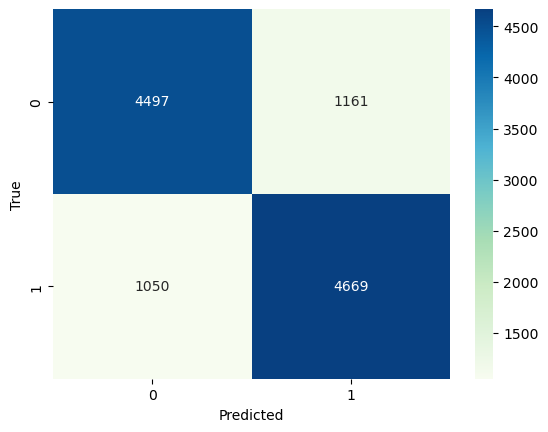

In [56]:
tabla=confusion_matrix(y_test, y_pred)
sns.heatmap(tabla,cmap='GnBu',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

Presentamos las reglas conseguidas en árbol no optizado:

In [57]:
reglas = export_text(tree_model, feature_names=list(hotelsdfArbol_x.columns.tolist()))
print(reglas)

|--- deposit_type_Non Refund <= 0.50
|   |--- lead_time <= 11.50
|   |   |--- previous_cancellations_num <= 0.50
|   |   |   |--- required_car_parking_spaces_num <= 0.50
|   |   |   |   |--- lead_time <= 5.50
|   |   |   |   |   |--- special_requests_num <= 0.50
|   |   |   |   |   |   |--- booking_changes_num <= 0.50
|   |   |   |   |   |   |   |--- weekend_nights_num <= 1.50
|   |   |   |   |   |   |   |   |--- average_daily_rate <= 21.30
|   |   |   |   |   |   |   |   |   |--- arrival_week_number <= 7.50
|   |   |   |   |   |   |   |   |   |   |--- arrival_month_day <= 13.00
|   |   |   |   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |   |   |   |--- arrival_month_day >  13.00
|   |   |   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |   |   |--- arrival_week_number >  7.50
|   |   |   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |   |--- average_daily_rate >  21.30
|   |   |   |   |   |   |   |   |   |-

A continuacion vamos a graficar el arbol resultante: \
(**Advertencia**: Suele tardar unos minutos en terminar de renderizar la imagen)

In [58]:
plt.figure(figsize=(100,100))

tree_plot_completo=tree.plot_tree(model,
                                 feature_names=hotelsdfArbol_x.columns.to_list(),
                                 filled=True,
                                 rounded=True,
                                 class_names=['Not Canceled','Is canceled']) #model.classes_
plt.show(tree_plot_completo)

Con la imagen se ve que el arbol resultante tiene unas dimensiones exageradas, vemos ademas que tiene una profundidad de 20 como especificamos

Vemos que en un árbol sin optimizar de profundidad 20 y sin configurar una mejora en los hiperparametros obtenemos las siguientes metricas:

In [59]:
accuracy=accuracy_score(y_test,y_pred)
recall=recall_score(y_test,y_pred)
f1=f1_score(y_test,y_pred,)
precision=precision_score(y_test,y_pred)

print("Accuracy: "+str(accuracy))
print("Recall: "+str(recall))
print("Precision: "+str(precision))
print("f1 score: "+str(f1))

Accuracy: 0.8056605432011954
Recall: 0.8164014687882497
Precision: 0.8008576329331046
f1 score: 0.8085548532340462


In [60]:
#dump(model, 'modelos1/arbolIneficiente.joblib')
#Cargamos el modelo de una de nuestras corrida. Este modelo no deberia variar mucho entre corrida y corrida
model = load('modelos/arbolIneficiente.joblib')

In [61]:
#Realizamos una predicción sobre el set de test
y_pred = model.predict(hotelsdfTesteo)
#Valores Predichos
y_pred

array([1, 1, 0, ..., 1, 0, 0])

In [62]:
df_submission = pd.DataFrame({'id': hotelsdfTesteoOriginal['id'], 'is_canceled': y_pred})
df_submission.head()

id  is_canceled
0  e6d0d58a-ab96-44d3-b28f-85df1cc15f1e            1
1  aba9aac2-4495-4645-a60e-90328713c999            1
2  b345b5dc-c804-4d77-a39f-1f4e65d1f1ad            0
3  ce1b400e-afa1-4946-bdff-004b859eb61c            1
4  c4fbec0d-8e2e-4db2-9d4f-a6ccb9f51214            1

In [63]:
df_submission.to_csv('submissions/arbol_decisiones_ineficiente.csv', index=False)

Con este modelo, obtuvimos el siguiente resultado:

![PrimeraEntrega](informe/images/primeraPrediccion.jpg)

# Busqueda de hiperparametros, poda y validación cruzada

## Randomized Search Cross Validation

Mediante la tecnica de ramdomized search cross validations hacemos una busqueda de los mejores hiperparametros

Tomamos 15 combinaciones posibles entre los parametros existentes y buscamos la combinación que mejor optimiza la metrica F1. La decisión de mejorar la metrica F1 viene de equilibrar tanto presion y recall debido a que la naturaleza del problema no requiere la mejora de alguna en particular, lo que significa que clasifica correctamente la mayoria de los casos positivos y encuentra la maxima cantidad de ellos

Nos basamos en los siguientes parametros:

In [64]:
combinaciones=15
limite_hojas_nodos = list(range(2, 50))
valor_poda = 0.0001 #0.0007
profundidad = list(range(0,40))
folds=10


params_grid = {'criterion':['gini','entropy'],
               'min_samples_leaf':limite_hojas_nodos,
               'min_samples_split': limite_hojas_nodos, 
               'ccp_alpha':np.linspace(0,valor_poda,combinaciones),
               'max_depth':profundidad}

kfoldcv = StratifiedKFold(n_splits=folds)

base_tree = DecisionTreeClassifier() 

scorer_fn = make_scorer(sk.metrics.f1_score)

randomcv = RandomizedSearchCV(estimator=base_tree,
                              param_distributions = params_grid,
                              scoring=scorer_fn,
                              cv=kfoldcv,
                              n_iter=combinaciones) 

randomcv.fit(x_train,y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
                   estimator=DecisionTreeClassifier(), n_iter=15,
                   param_distributions={'ccp_alpha': array([0.00000000e+00, 7.14285714e-06, 1.42857143e-05, 2.14285714e-05,
       2.85714286e-05, 3.57142857e-05, 4.28571429e-05, 5.00000000e-05,
       5.71428571e-05, 6.42857143e-05, 7.14285714e-05, 7.85714286e-05,
       8....
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': [0, 1, 2, 3, 4, 5, 6, 7, 8,
                                                      9, 10, 11, 12, 13, 14, 15,
                                                      16, 17, 18, 19, 20, 21,
                                                      22, 23, 24, 25, 26, 27,
                                                      28, 29, ...],
                                        'min_samples_leaf': [2, 3, 4, 5, 6, 7,
                                                             8, 9, 10, 11, 12,
                                                             13, 14, 15, 16, 17,
                                                             18, 19, 20, 21, 22,
                                                             23, 24, 25, 26, 27,
                                                             28, 29, 30, 31, ...],
                                        'min_samples_split': [2, 3, 4, 5, 6, 7,
                                                              8, 9, 10, 11, 12,
                                                              13, 14, 15, 16,
                                                              17, 18, 19, 20,
                                                              21, 22, 23, 24,
                                                              25, 26, 27, 28,
                                                              29, 30, 31, ...]},
                   scoring=make_scorer(f1_score))

Mostramos los mejores hiperparametros devueltos por el arbol y el valor del f1_score

In [65]:
print("Mostramos los mejores resultados: ")
print(randomcv.best_params_)
print()
print("Mostramos el mejor resultado obtenido de busqueda aleatoria: ")
print("f1_score = ",randomcv.best_score_)

Mostramos los mejores resultados: 
{'min_samples_split': 3, 'min_samples_leaf': 12, 'max_depth': 36, 'criterion': 'entropy', 'ccp_alpha': 6.428571428571429e-05}

Mostramos el mejor resultado obtenido de busqueda aleatoria: 
f1_score =  0.8058833381742166


Algunos valores obtenidos del algoritmo

In [66]:
randomcv.cv_results_['mean_test_score']

array([0.80120628, 0.78551164, 0.80359058, 0.80406284, 0.48137508,
       0.80499184, 0.79974157, 0.78390242, 0.8019171 , 0.48137508,
       0.80284533, 0.71606112, 0.80404206, 0.80588334, 0.78523589])

## Predicción y Evaluación del Modelo con mejores hiperparámetros

Generamos el árbol con los hiperparametros que optimizan su eficiencia y a su vez presentamos el conjunto de valores con su peso relativo a la toma de la decisión 

Cargamos el mejor arbol que encontramos (explicado en la seccion de validacion cruzada)

In [67]:
arbol_mejores_parametros = load('modelos/arbolEficiente.joblib')

In [68]:
arbol_mejores_parametros=DecisionTreeClassifier().set_params(**randomcv.best_params_)
arbol_mejores_parametros.fit(x_train,y_train)

DecisionTreeClassifier(ccp_alpha=6.428571428571429e-05, criterion='entropy',
                       max_depth=36, min_samples_leaf=12, min_samples_split=3)

*Conjunto de reglas:*

In [69]:
features_considerados = hotelsdfArbol_x.columns.to_list()
best_tree = randomcv.best_estimator_
feat_imps = best_tree.feature_importances_

for feat_imp,feat in sorted(zip(feat_imps,features_considerados)):
  if feat_imp>0:
    print('{}: {}'.format(feat,feat_imp))

arrival_month_December: 0.00015394284044676344
arrival_month_January: 0.00019776901789086222
assigned_room_type_F: 0.00021048751455625967
continente_South America: 0.00021187937957648122
continente_North America: 0.00026879916056568126
reserved_room_type_B: 0.0002752923575096166
assigned_room_type_E: 0.0002815348081956609
meal_type_Undefined: 0.0002876587685605484
market_segment_type_Corporate: 0.00044560121837721334
children_num: 0.00048102134544795327
market_segment_type_Groups: 0.0005247290096143702
reserved_room_type_E: 0.00062430617489469
meal_type_FB: 0.0007370821366606591
arrival_month_September: 0.0008695093393393873
arrival_month_August: 0.0009918249447569056
meal_type_SC: 0.0010004236576432889
market_segment_type_Direct: 0.001079895703485174
arrival_month_February: 0.0011432997903631002
arrival_month_March: 0.0012842898225702416
distribution_channel_TA/TO: 0.001563266240836886
assigned_room_type_B: 0.0015774919631910815
arrival_month_June: 0.001583124247171454
arrival_month_J

Es importante destacar que tres de las variables seleccionadas en la primera parte de nuestro analisis (Checkpoint 1):  lead_time, average_daily_rate y previous_cancelations_nums estan enmarcadas dentro de las diez caracteristicas que aportan màs información en la construcción del árbol

*Mostramos las reglas internas del árbol:*

In [70]:
reglas = export_text(arbol_mejores_parametros, feature_names=list(features_considerados))
print(reglas)

|--- deposit_type_Non Refund <= 0.50
|   |--- required_car_parking_spaces_num <= 0.50
|   |   |--- previous_cancellations_num <= 0.50
|   |   |   |--- market_segment_type_Online TA <= 0.50
|   |   |   |   |--- booking_changes_num <= 0.50
|   |   |   |   |   |--- special_requests_num <= 0.50
|   |   |   |   |   |   |--- customer_type_Transient-Party <= 0.50
|   |   |   |   |   |   |   |--- average_daily_rate <= 115.12
|   |   |   |   |   |   |   |   |--- agent_id <= 512.00
|   |   |   |   |   |   |   |   |   |--- assigned_room_type_D <= 0.50
|   |   |   |   |   |   |   |   |   |   |--- lead_time <= 16.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 11
|   |   |   |   |   |   |   |   |   |   |--- lead_time >  16.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 15
|   |   |   |   |   |   |   |   |   |--- assigned_room_type_D >  0.50
|   |   |   |   |   |   |   |   |   |   |--- reserved_room_type_D <= 0.50
|   |   |   |   |   |   |

Se puede observar una considerable simplificacion en la ramificacion de las reglas de este árbol comparado contra el primer árbol generado en el análisis 

### Grafica representativa del árbol optimizado

Mostramos los primeros cinco niveles del árbol optimazado y observamos una diferencia con el primer árbol generado en el analisis:

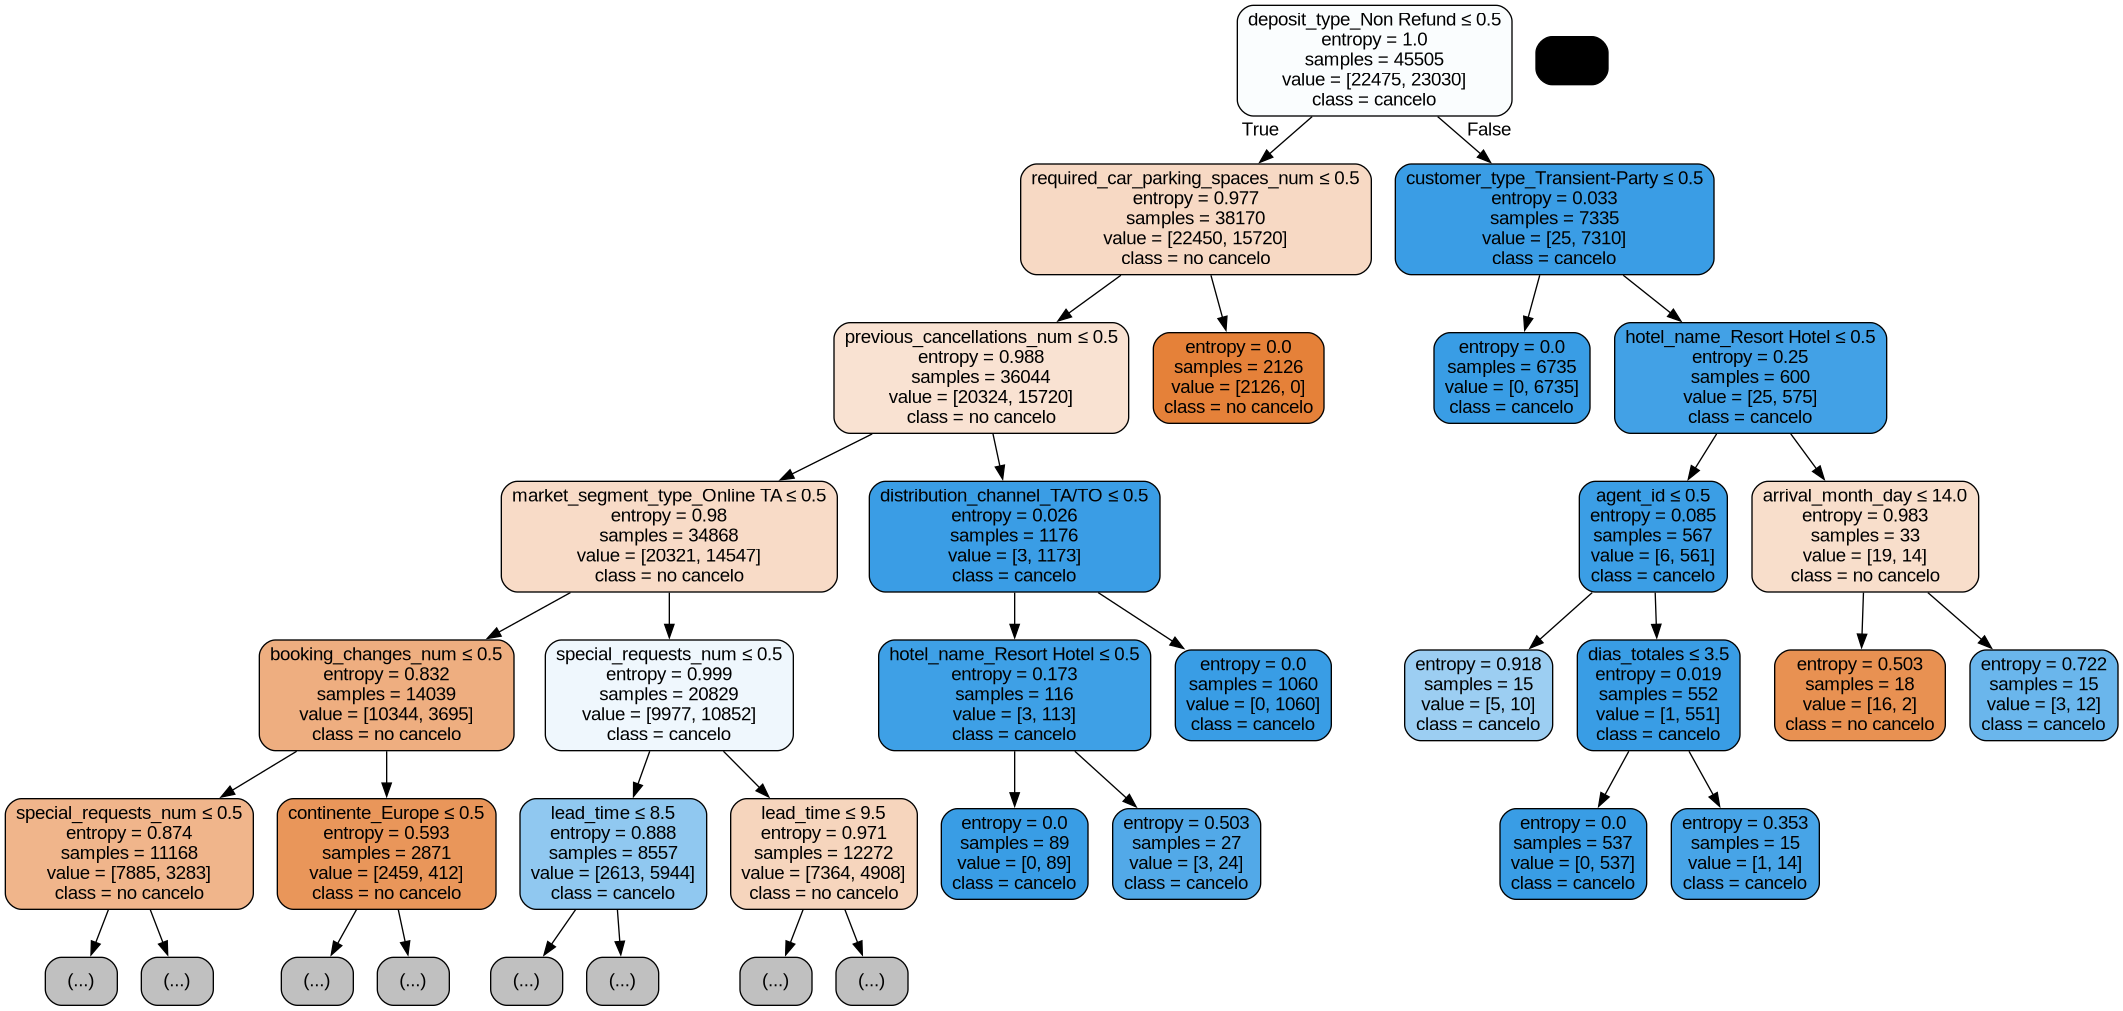

In [71]:
dot_data = StringIO()
export_graphviz(arbol_mejores_parametros, out_file=dot_data,  
                 filled=True, rounded=True,
                 special_characters=True,
                 feature_names=features_considerados,
                 class_names=['no cancelo','cancelo'],
                 max_depth=5)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

Considerando lo antes mencionado podemos apreciar que:
1. El primer nodo particiona segun el tipo de deposito: sin rembolso, donde, la gente tiende a mantener la reserva y con rembolso donde se tiende a cancelar
2. El segundo nivel árbol toma en consideración la cantidad de espacios de estacionamiento requerido y si el tipo de cliente es Transient Party. La primera variable es discreta; la segunda variable es binaria (o vale 1 o vale 0). Esta ultima fue generada en el proceso de one hot encoding
3. En un tercer nivel observamos que las variables que más informacion aportan son: previous cancelation number y hotel name

### Prediccion con split de train

Hacemos una primera evaluación del árbol haciendo uso de los datos de prueba y medimos su desempeño

F1-Score: 0.8026455026455027


Text(0.5, 1.0, 'Desempeño del modelo con datos de prueba')

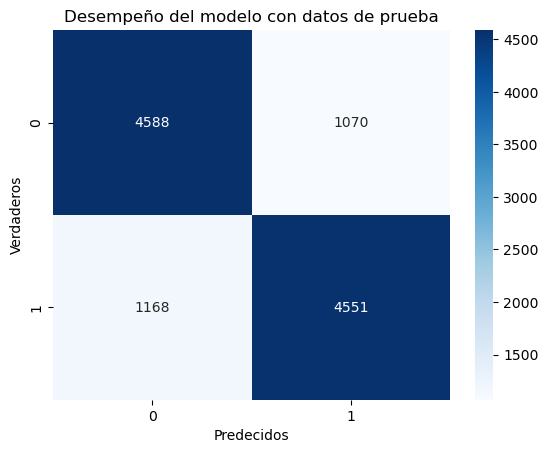

In [72]:
y_pred= arbol_mejores_parametros.predict(x_test)
print('F1-Score: {}'.format(f1_score(y_test, y_pred, average='binary')))
cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predecidos')
plt.ylabel('Verdaderos')
plt.title("Desempeño del modelo con datos de prueba")

*Un vistazo al primer conjunto de prediccione:*

In [73]:
arbol_mejores_parametros.predict_proba(x_test)

array([[0.75      , 0.25      ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       ...,
       [0.89473684, 0.10526316],
       [0.        , 1.        ],
       [0.30952381, 0.69047619]])

## Entrenamiento Cross Validation

Procedemos a realizar entrenamiento del árbol mediante el metodo de la validación cruzada en 10 folds considerando que fue como se entreno previamente al árbol mas optimo. Esto buscando siempre mantener la metrica F1 en su valor más alto, como también comprobar que el árbol mantiene un desempeño esperado y detectar posibles casos de *Overfitting o Underfitting*

In [74]:
kfoldcv =StratifiedKFold(n_splits=folds) 
scorer_fn = make_scorer(sk.metrics.f1_score)

resultados = cross_validate(arbol_mejores_parametros,x_train, y_train, cv=kfoldcv,scoring=scorer_fn,return_estimator=True)

metricsCV = resultados['test_score']

arbol_mejor_performance = resultados['estimator'][np.where(metricsCV==max(metricsCV))[0][0]]

Text(0.5, 1.0, 'Modelo entrenado con 10 folds')

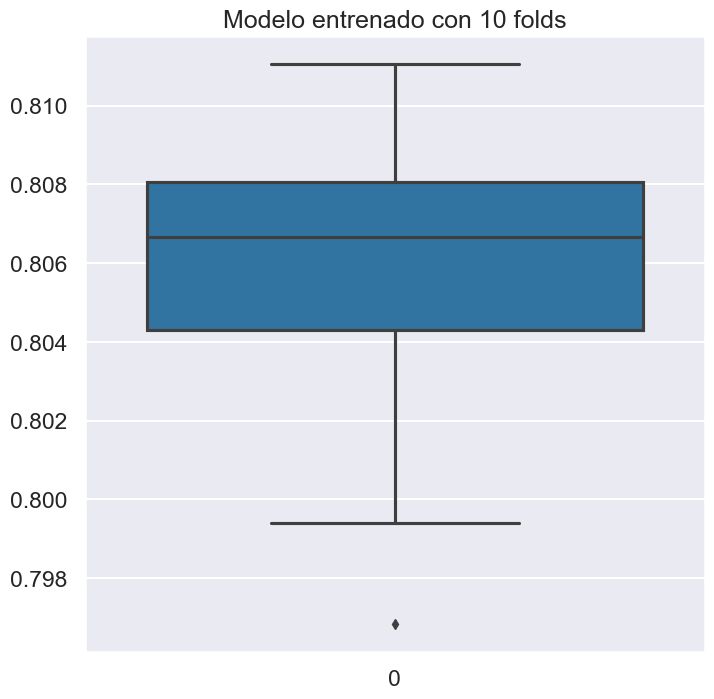

In [75]:
metric_labelsCV = ['F1 Score']*len(metricsCV) 
sns.set_context('talk')
sns.set_style("darkgrid")
plt.figure(figsize=(8,8))
sns.boxplot(metricsCV)
plt.title("Modelo entrenado con 10 folds")

              precision    recall  f1-score   support

           0       0.80      0.82      0.81      5658
           1       0.81      0.80      0.80      5719

    accuracy                           0.81     11377
   macro avg       0.81      0.81      0.81     11377
weighted avg       0.81      0.81      0.81     11377

F1-Score: 0.8048456981165444


Text(37.08333333333333, 0.5, 'True')

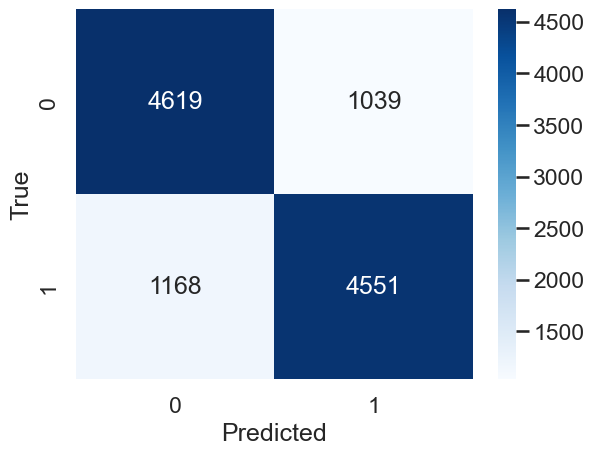

In [76]:
y_pred= arbol_mejor_performance.predict(x_test)
print(classification_report(y_test,y_pred))
print('F1-Score: {}'.format(f1_score(y_test, y_pred, average='binary'))) 
cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

Se determina que de la anterior busqueda de hiperparametros mediante la validacion cruzada, el ultimo arbol obtenido es el arbol mas eficiente entrenado hasta el momento.\
Es por esto que lo guardamos para que pueda ser cargado para uso posterior

In [77]:
#dump(arbol_mejores_parametros, 'modelos/arbolEficiente.joblib')
#Cargamos el modelo de una de nuestras corrida. Este modelo no deberia variar mucho entre corrida y corrida

In [78]:
#Realizamos una predicción sobre el set de test
y_pred = arbol_mejores_parametros.predict(hotelsdfTesteo)
#Valores Predichos
y_pred

array([1, 1, 0, ..., 1, 0, 0])

In [79]:
df_submission = pd.DataFrame({'id': hotelsdfTesteoOriginal['id'], 'is_canceled': y_pred})
df_submission.head()

id  is_canceled
0  e6d0d58a-ab96-44d3-b28f-85df1cc15f1e            1
1  aba9aac2-4495-4645-a60e-90328713c999            1
2  b345b5dc-c804-4d77-a39f-1f4e65d1f1ad            0
3  ce1b400e-afa1-4946-bdff-004b859eb61c            1
4  c4fbec0d-8e2e-4db2-9d4f-a6ccb9f51214            1

In [80]:
df_submission.to_csv('submissions/arbol_decisiones_eficiente.csv', index=False)

# Conclusión

1. Al comparar los dos modelos construidos, se observó una mejora considerable en el segundo modelo en factores como la performance y las métricas en comparación con el primero. Esto sugiere que se pudo optimizar significativamente el modelo mediante la incorporación de tecnicas como: ramdomized cross search
2. Las métricas del árbol se mejoraron mediante la optimización del F1 score, el cual fue seleccionado debido a la naturaleza del problema en el que no había un motivo particular para seleccionar una métrica específica (como recall o precision).
3. A pesar de la poda y la reducción de la libertad del árbol para extenderse, se logró una mejora significativa en su métrica F1. Esto demuestra que la poda y la limitación de la extensión del árbol no necesariamente afectan negativamente su rendimiento, sino que pueden mejorar la capacidad de generalización del modelo.
4. Se realizaron repetidas pruebas sobre el modelo buscando mejorar el f1 score, de todos estos intentos se alamaceno el que mejor balanceaba eficiencia con f1 score.  